# Практическая работа №4. Дисперсионный анализ

## Цели:
- знакомство с теоретическими основами дисперсионного анализа;
- формирование навыков выполнения многофакторного дисперсионного анализа с помощью языка программирования Python.
## Задачи:
- проверка гипотезы о равенстве групповых математических ожиданий.
## Исходные данные:
Успеваемость студентов на экзаменах (<a href="https://www.kaggle.com/spscientist/students-performance-in-exams">Students Performance in Exams</a>)

In [13]:
# Импорты
# a b c d e f g h i j k l m n o p q r s t u v w x y z
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [2]:
dataframe = pd.read_csv("StudentsPerformance.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [3]:
dataframe.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
new_columns = []
for column in dataframe.columns:
    new_columns.append(column.replace(" ", "_"))

dataframe.columns = new_columns

quantitative_columns = [*dataframe.columns[(dataframe.dtypes.values == np.dtype('int64'))]]
categorical_columns = [*dataframe.columns[(dataframe.dtypes.values == np.dtype('object'))]]

for column in categorical_columns:
    print(dataframe[column].value_counts())

female    518
male      482
Name: gender, dtype: int64
group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental_level_of_education, dtype: int64
standard        645
free/reduced    355
Name: lunch, dtype: int64
none         642
completed    358
Name: test_preparation_course, dtype: int64


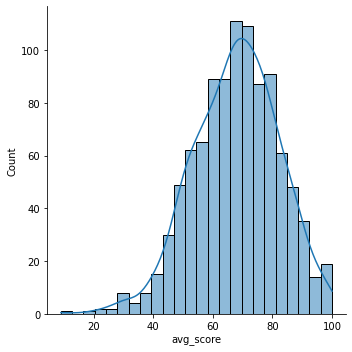

In [5]:
dataframe["avg_score"] = dataframe[['math_score', 'reading_score', 'writing_score']].mean(axis=1)

sns.displot((dataframe.avg_score), kde=True)

In [53]:
def make_groups(column, size=50, by="avg_score", seed=int(time.time())):
    groups = []
    group_names = dataframe[column].unique()
    for group_name in group_names:
        group = dataframe[by][dataframe[column] == group_name].sample(size, random_state=seed)
        groups.append(group)
    return pd.DataFrame(data={f"group{i}": group.values for i, group in enumerate(groups, start=1)})

groups1 = make_groups("race/ethnicity", 50, by="avg_score")
groups2 = make_groups("parental_level_of_education", 50, by="avg_score")

## (#1) Проверка выборки на независимость с помощью критерия $\chi^2$ Пирсона.

In [43]:
ALHA_SYM = "\u03B1"
alpha = 0.05

_, p_value, _, _ = stats.chi2_contingency(groups1, correction=False)
is_independent = p_value >= alpha

sign = ">=" if is_independent else "<"
print(f"Выборки независимы? {is_independent} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Выборки независимы? False (p-value=0.000 < α=0.05)


## (#2) Проверка выборки на нормальность распределений

In [54]:
alpha = 0.01

for group in groups1.columns:
    _, p_value = stats.shapiro(groups1[group].values)
    is_normal = p_value >= alpha

    sign = ">=" if is_normal else "<"
    print(f"{group} распределена нормально? {is_normal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

group1 распределена нормально? True (p-value=0.262 >= α=0.01)
group2 распределена нормально? True (p-value=0.836 >= α=0.01)
group3 распределена нормально? True (p-value=0.840 >= α=0.01)
group4 распределена нормально? True (p-value=0.559 >= α=0.01)
group5 распределена нормально? True (p-value=0.493 >= α=0.01)


In [55]:
alpha = 0.01

_, p_value = stats.kruskal(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Медианы в группах равны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Медианы в группах равны? True (p-value=0.023 >= α=0.01)


## (#3) Проверка гипотезы об однородности дисперсий

Дисперсии однородны? True (p-value=0.834 >= α=0.05)


<AxesSubplot:>

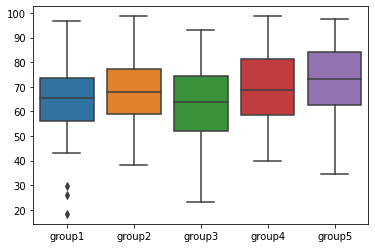

In [62]:
alpha = 0.05
_, p_value = stats.levene(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Дисперсии однородны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")
sns.boxplot(data=groups1)

## (#4) Средние и стандартные отклонения по группе

In [26]:
print("Мат. ожидания")
print(groups1.mean())

print("Стандартные отклонения")
print(groups1.std())

Мат. ожидания
group1    66.326667
group2    66.266667
group3    62.740000
group4    69.380000
group5    70.733333
dtype: float64
Стандартные отклонения
group1    13.111849
group2    15.266046
group3    15.293840
group4    10.941404
group5    14.862636
dtype: float64


## (#5) Проверка гипотезы о равенстве средних

In [63]:
_, p_value = stats.f_oneway(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Мат. ожидания однородны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Мат. ожидания однородны? False (p-value=0.014 < α=0.05)


## (#6) 